# Applying Time Series Regression to Ocean Gauge Data

Christopher Liu 

Contact: cmhl@uw.edu

Last change - 10/8/2020 Added classifcation problem

Previous changes

* 9/30/2020, added mag and lat, plots to compare different size windows
* 9/18/2020, added scaling for the feature dataframes

-----
[tsfresh](https://tsfresh.readthedocs.io/) is required to run this notebook

In [1]:
%matplotlib inline

In [2]:
import numpy as np

from scipy.interpolate import interp1d

from pylab import *
from IPython.display import Image

np.set_printoptions(threshold=1000) # edit as needed

## Plots

Plots of the original uninterpolated data. Time series, slip on fault and surface deformation. Only contains runs 600-699

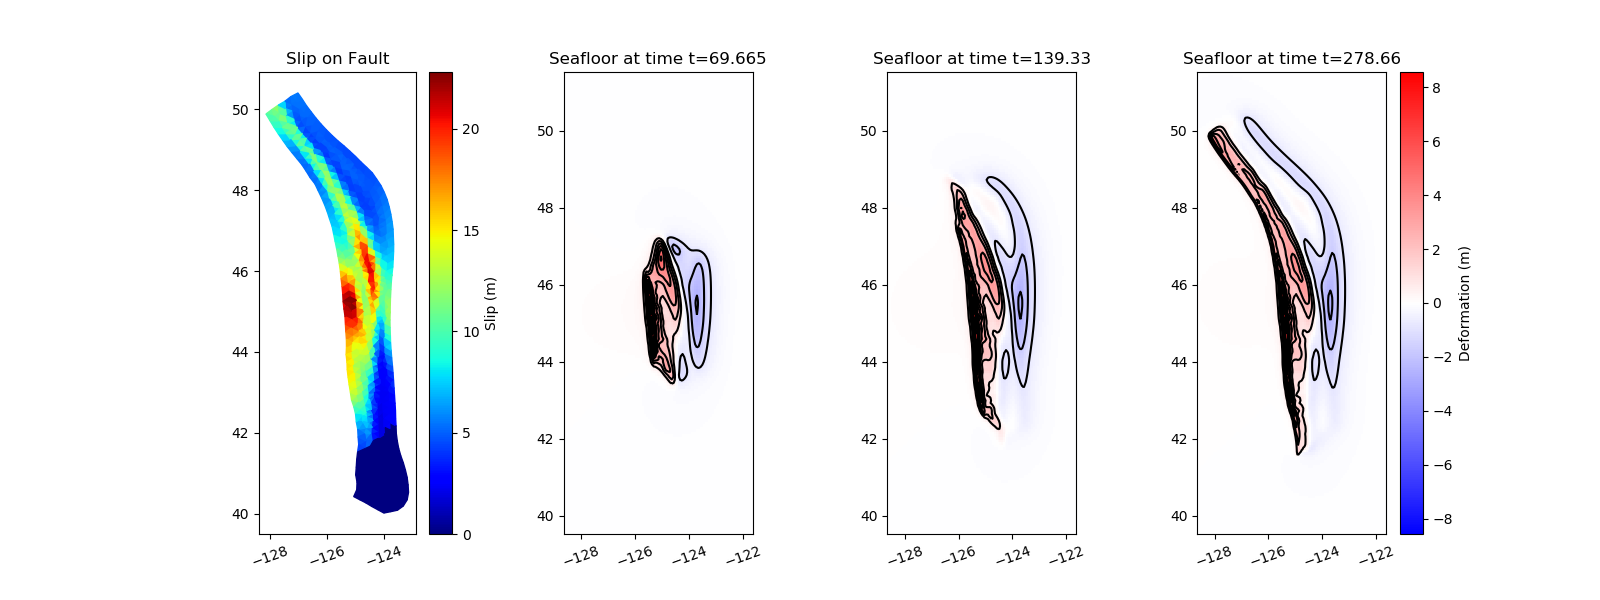

In [3]:
rnum = 1297   # run number
dtopo_png = 'C:/Users/Chris/Desktop/SJDF_files/dtopo/cascadia%s.png' % str(rnum).zfill(6)
Image(dtopo_png, width=900)

In [4]:
# (Un)comment as needed

# rnums = range(608,609)
# etamax = {}

# figure(figsize=(12,6))
# for rnum in rnums:
#     outdir = 'C:/Users/Chris/Desktop/SJDF_files/gauges/run_%s/_output' % str(rnum).zfill(6)
#     #print('outdir = ', outdir)

#     gaugenos = [702]
#     for gaugeno in gaugenos:
#         gfile = '%s/gauge%s.txt' % (outdir, str(gaugeno).zfill(5))
#         gdata = loadtxt(gfile)
#         t = gdata[:,1] / 60.  # minutes
#         eta = gdata[:,5]  # surface elevation in meters
#         plot(t, eta, label='Run # %s' % rnum)
#         etamax[(rnum,gaugeno)] = eta.max()

# xlim(0, 360)
# xlabel('Minutes after quake')
# ylabel('Surface elevation (meters) and scaled momenutm')
# grid(True)
# legend()

# Load Data

Loads the interpolated time series data. This step can be skipped if loading the features/data frame directly

In [5]:
rnums = range(0,1300)
gaugenos = [702,712,901,902,911,912]

eta = {}
t = {}
for rnum in rnums:
    outdir = 'C:/Users/Chris/Desktop/gauge_data/run_%s/' % str(rnum).zfill(6)
    
    for gaugeno in gaugenos:
        gfile = '%s/gauge%s.txt' % (outdir, str(gaugeno).zfill(5))
        g_data = np.genfromtxt(gfile, delimiter=',')
        
        # data in this case has a NaN value for eta @ t=0
        t[(rnum,gaugeno)] = g_data[1:,0]  # seconds

        eta[(rnum,gaugeno)] = g_data[1:,1]  # surface elevation in meters

In [6]:
# Code for plotting some of the data. (Un)comment as needed

# gnum = 911
# rnum = 1000

# plot(t[(rnum,gnum)]/60,eta[(rnum,gnum)])

# xlim(0, 360)
# xlabel('Minutes after quake')
# ylabel('Surface elevation (meters)')
# grid(True)

# Featurize

In [7]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

from tsfresh import extract_features, select_features
from tsfresh.feature_selection import relevance
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, settings

In [8]:
def max_eta(data,gaugeno,runs):
    """
    Finds the max eta for a specific gauge and run(s)
    Input:
        data - Dictionary of timeseries data with the form: data[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - List or range of run numbers to find the max value for
    
    Output:
        eta_max - np array containing the maximum values.
    """
    eta_max = []
    for rnum in runs:
        eta_max.append(np.amax(data[(rnum,gaugeno)]))
    return np.array(eta_max)

In [9]:
def get_thresh(data,threshold):
    """
    Finds index of time series when threshold is met or exceeded
    Input:
        data - Numpy array of time series
        threshold - int/double that each entry in the time series is compared against 
        
    Returns:
        i - Integer index of time series when threshold is met or exceeded
            OR
        math.nan - Returns NaN if threshold is not met/exceeded
    """
    for i in range(len(data)):
        if np.abs(data[i]) >= threshold:
            return i
    return math.nan

In [10]:
def stack_series(data, time, gaugeno, runs, threshold, tsteps, subs_thresh, subs_time):
    
    """
    Stacks the time series used to construct the dataframe for feature extraction with thresholding.
    Input:
        data - Dictionary of eta data with the form: data[(run_number, gauge_number)]
        time - Dictionary of time intervals of the form: time[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - Integer total number of runs
        threshold - int/double that each entry in the time series is compared against 
        tsteps - Number of time steps to extract after threshold is met
        subs_thresh - Threshold for average initial subsidence
        subs_time - Time steps over which the average subsidence is taken
        
    Returns:
        g - Stacked eta time series of the form [(Run#0000,Gauge#702),(Run#0001,Gauge#702), ..., (Run#1299,Gauge#702)]
        run_id - ID used to identify which run number the time series belongs to, ranges from 0 to 1299
        runs_used - List containing the run numbers used (met the threshold). Not used for feature extraction
        times - The time scale/interval corresponding to an eta time series
        tstart - The indices where each time series met or exceeded the threshold. Not used for feature extraction
    """
    rnums = range(0,runs)
    
    runs_used = []
    g = []
    times = []
    run_id = []
    tstart = []
    
    for rnum in rnums:
        g_data = data[(rnum,gaugeno)]
        t_data = time[(rnum,gaugeno)]
        ind = get_thresh(g_data,threshold) #returns NaN if threshold is not met/exceeded
        
        if math.isnan(ind) == False and np.average(g_data[0:subs_time]) > subs_thresh: #ignore run if NaN
            runs_used.append(rnum)
            tstart.append(ind)
            
            #checking to see if there is enough data after threshold is met/exceeded
            if ind+tsteps < len(g_data):
                g.extend(g_data[ind:ind+tsteps].tolist())
                times.extend(t_data[ind:ind+tsteps].tolist())
                run_id.extend((np.ones(tsteps)*rnum).tolist())
            else:
                g.extend(g_data[ind:].tolist())
                times.extend(t_data[ind:].tolist())
                run_id.extend((np.ones(len(g_data)-ind)*rnum).tolist())

    return g, run_id, runs_used, times, tstart

In [11]:
def stack_series_all(data, time, gaugeno, runs):
    """
    Stacks the time series used to construct the dataframe for feature extraction without thresholding.
    Input:
        data - Dictionary of eta data with the form: data[(run_number, gauge_number)]
        time - Dictionary of time intervals of the form: time[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - Integer total number of runs
        
    Returns:
        g - Stacked eta time series of the form [(Run#0000,Gauge#702),(Run#0001,Gauge#702), ..., (Run#1299,Gauge#702)]
        run_id - ID used to identify which run number the time series belongs to, ranges from 0 to 1299
        times - The time scale/interval corresponding to an eta time series
    """
    
    rnums = range(0,runs)
    
    g = []
    times = []
    run_id = []
    
    for rnum in rnums:
        g_data = data[(rnum,gaugeno)]
        t_data = time[(rnum,gaugeno)]
        
        g.extend(g_data.tolist())
        times.extend(t_data.tolist())
        run_id.extend((np.ones(len(g_data))*rnum).tolist())

    return g, run_id, times

In [12]:
def max_eta_all(data,gaugeno,runs):
    """
    Finds the max eta for all runs and a specific gauge 
    Input:
        data - Dictionary of timeseries data with the form: data[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - Number of runs
    
    Output:
        eta_max - np array containing the maximum values.
    """
    eta_max = []
    for rnum in range(runs):
        eta_max.append(np.amax(data[(rnum,gaugeno)]))
    return np.array(eta_max)

In [13]:
tsteps = [181, 361] # 30 minutes
threshold = 0.1
sub_thresh = -2 # set to arbitrarily large negative number if you do not want to filter for subsidence
sub_time = 31

eta_g702 = []
run_id = []
runs_used = []
times = []
tstart = []

for i in range(len(tsteps)):
    eta_tmp, run_id_tmp, runs_used_tmp, times_tmp, tstart_tmp =\
        stack_series(eta, t, 702, 1300, threshold, tsteps[i], sub_thresh, sub_time)
    
    eta_g702.append(eta_tmp)
    run_id.append(run_id_tmp)
    runs_used.append(runs_used_tmp)
    times.append(times_tmp)
    tstart.append(tstart_tmp)

#### Histogram of when time when threshold is met/exceeded

Text(0, 0.5, 'Frequency')

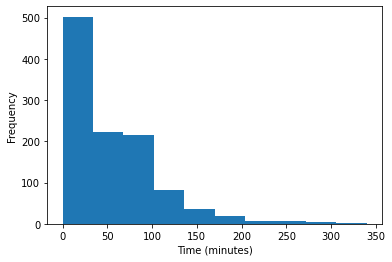

In [14]:
plt.hist(np.array(tstart[0])*(1/6))
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')

### Create dataframe and extract features
Skip if loading features from a .csv

In [15]:
# This takes awhile to run. Keep commented if you are worried about accidentally running all cells. 
feat702 = []

for i in range(len(eta_g702)):
    dict = {'id':run_id[i], 'time':times[i], 'eta': eta_g702[i]}
    
    feat_temp = extract_features(pd.DataFrame(dict), column_id='id', column_sort='time',
                        default_fc_parameters=ComprehensiveFCParameters(), impute_function=impute)
    
    # drop constant features
    feat702.append(feat_temp.loc[:, feat_temp.apply(pd.Series.nunique) != 1]) 
    
# export datafrane used for feature extraction 
# df.to_csv(r'GaugeData1hr_818.csv', index=False) 

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.87s/it]


In [16]:
# Extract feature settings for model prediction
params_30min = settings.from_columns(feat702[0])
params_60min = settings.from_columns(feat702[1])

### Import/Export feature dataframe
Comment/Uncomment as needed

In [17]:
# importing or exporting features to save computation time

# export features
# feat702[0].to_csv(r'feat702_all_910.csv', index=False)

# import features
# feat702 = []
# feat702[0] = pd.read_csv (r'feat702_all_910.csv')

### Creating/loading the max eta for desired gauges
Comment/uncomment the relevant block

#### Regression

In [18]:
# Creating/loading the max eta for desired gauges

# find max eta for gauge, starting time is the same so runs_used should be as well

g901max = max_eta(eta,901,runs_used[0])
g902max = max_eta(eta,902,runs_used[0])
g911max = max_eta(eta,911,runs_used[0])
g912max = max_eta(eta,912,runs_used[0])

# find max eta for gauges, all runs

# g901max = max_eta_all(eta,901,1300)
# g902max = max_eta_all(eta,902,1300)
# g911max = max_eta_all(eta,911,1300)
# g912max = max_eta_all(eta,912,1300)

# load max eta for gauges

# g901max = np.loadtxt('g901max.csv', delimiter=',')
# g902max = np.loadtxt('g902max.csv', delimiter=',')
# g911max = np.loadtxt('g911max.csv', delimiter=',')
# g912max = np.loadtxt('g912max.csv', delimiter=',')

# save max eta for gauges

# savetxt('g901max.csv', g901max, delimiter=',')
# savetxt('g902max.csv', g912max, delimiter=',')
# savetxt('g911max.csv', g901max, delimiter=',')
# savetxt('g912max.csv', g912max, delimiter=',')

#### Classification
Create labels for classification

In [19]:
def classify_labels(maxeta,cat):
    labels = []
    for gmax in maxeta:
        if gmax < cat[0]:
            labels.append('A')
        elif gmax < cat[1]:
            labels.append('B')
        elif gmax < cat[2]:
            labels.append('C')
        else:
            labels.append('D')
    return np.array(labels)

In [20]:
categories = [2,4,6]

g901max_c = classify_labels(g901max,categories)
g902max_c = classify_labels(g902max,categories)
g911max_c = classify_labels(g911max,categories)
g912max_c = classify_labels(g912max,categories)

### Filter features

Refer to https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html for more info. (Un)comment relevant block as needed

In [21]:
def filter_features(feat,gmax, c_or_r):
    """
    Filters the features using the select_features function from the tsfresh library.
    Input:
        feat - List of feature dataframes
        gmax - Target values that the features are compared against (max eta for a gauge in this case).
        c_or_r - Character denoting machine learning task of interest (classification of regression)
    Output:
        filtered - List of filtered feature dataframes.
    """
    
    if c_or_r == 'c':
        type = 'classification'
    elif c_or_r == 'r':
        type = 'regression'
    else:
        raise Exception("Invalid input")
    
    filtered = []
    for i in range(len(feat)):
            filtered.append(select_features(feat[i],gmax,ml_task=type))
    return filtered

In [22]:
# Filter features

feat702_filt901 = filter_features(feat702, g901max, 'r')
feat702_filt902 = filter_features(feat702, g902max, 'r')
feat702_filt911 = filter_features(feat702, g911max, 'r')
feat702_filt912 = filter_features(feat702, g912max, 'r')

## Build and Test Model

In [23]:
from sklearn.svm import SVR, SVC, LinearSVC
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import explained_variance_score, accuracy_score

from matplotlib.lines import Line2D

In [24]:
# Inputs and some constants and used for training and visualization

# Uncomment this if using all runs (no thresholding)
# runs_used = np.arange(1300)

testsize = 0.4

plotlabels = ['60 min better', '30 min better']

rseed = 1 # random seed used for train/test split

In [25]:
def train_test_split(data, target, runs_used, test_size, seed):
    """
    Splits data and target into training and testing sets for a given random seed. Keeps track of which runs are
    put into training and testing sets.
    
    Input
        data - Dataframe of data samples
        target - np array of targets
        runs_used - np array of run numbers used
        test_size - test size as a fraction of the total samples (between 0 and 1)
        seed - seed used for random number generator
    Output
        train - Dataframe of training data
        test - Dataframe of testing data
        train_target - np array of training targets
        test_target - np array of testing targets
        train_runs - np array of run numbers in training data
        test_runs - np array of run numbers in testing data
    
    """
    np.random.seed(seed)
    
    total = len(target)
    
    tt_size = np.round(total*test_size)
    tr_size = int(total - tt_size)
    
    perm = np.random.permutation(total)
    
    train = data.iloc[perm[:tr_size]]
    train_target = target[perm[0:tr_size]]
    train_runs = runs_used[perm[0:tr_size]]
    
    test = data.iloc[perm[tr_size:]]
    test_target = target[perm[tr_size:]]
    test_runs = runs_used[perm[tr_size:]]
    
    return train, test, train_target, test_target, train_runs, test_runs

In [26]:
def train_test(feat, target, runs_used, scale, c_or_r, *returns):
    """
    Trains and tests the model using non-linear SVR/SVC. 
    
    Input:
        feat - List of feature dataframes
        target - Array of target values for regression
        runs_used - Array of run numbers in the model
        scale - Boolean value to denote whether features should be scaled or not to unit variance and 0 mean.
        c_or_r - Value for specifying classification or regression
        *returns - Boolean value to determine whether scalers and models need to be returned.
        
    Output:
        pred - List of arrays of predictions from testing the model after it is trained
        target - List of arrays of targets that correspond to runs in the test set
        runs - List arrays of runs used in testing.
        evs - List of explained variance scores for each dataset.
        scalers - List of standard scalers used (Optional)
        models - List of models used (Optional)
    """
    
    pred = []
    targets = []
    runs = []
    acc = []
    
    if returns:
        scalers = []
        models = []
    
    for i in range(len(feat)):
        train_set, test_set, train_target, test_target, train_runs, test_runs = \
            train_test_split(feat[i], target, np.asarray(runs_used[i]), test_size=testsize,seed=rseed)
        
        if scale:
            scaler = StandardScaler()
            train_set = scaler.fit_transform(train_set[train_set.columns])
            test_set = scaler.transform(test_set[test_set.columns])
        
        if c_or_r == 'r':
            model = SVR(kernel='rbf',gamma='scale')
        elif c_or_r =='c':
            model = LinearSVC(penalty='l2', loss='squared_hinge', tol=1e-4, max_iter= 5000)
        else:
            print('Invalid input')
            break
        
        model.fit(train_set, train_target, sample_weight=None)
        
        pred.append(model.predict(test_set))
        
        if c_or_r == 'r':
            acc.append(explained_variance_score(test_target,pred[i]))
        else:
            acc.append(accuracy_score(test_target,pred[i]))
            
        runs.append(test_runs)
        targets.append(test_target)
        
        if returns:
            models.append(model)
            scalers.append(scaler)
            
    if returns:
        return pred, targets, runs, acc, scalers, models
    else:
        return pred, targets, runs, acc

In [27]:
def plot_test_all(target,pred,line,zoomlim, labels):
    """
    Plots the predicted versus actual value for both datasets along with a reference line of slope 1.
    
    Input
        target - Target values
        pred - Predicted values
        line - Endpoint of reference line
        zoomlim - x and y limit for the zoomed in subplot
        labels - labels for the legend
    """
    #legend
    custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='g', lw=2)]
    
    fig = figure(figsize=(13,7))
    
    ax = fig.add_subplot(1,2,1)
    
    for i in range(shape(target)[1]):
        if np.abs(target[0][i] - pred[0][i]) > np.abs(target[1][i] - pred[1][i]):
            plt.plot([target[0][i],target[1][i]],[pred[0][i],pred[1][i]],'r-')
        elif np.abs(target[0][i] - pred[0][i]) < np.abs(target[1][i] - pred[1][i]):
            plt.plot([target[0][i],target[1][i]],[pred[0][i],pred[1][i]],'g-')
    
    plot([0,line],[0,line],'k--')
    
    ax.legend(custom_lines, labels)
    
    xlabel('Max eta (Actual)')
    ylabel('Max eta (Predicted)')
    
    plt.xlim(0,line)
    plt.ylim(0,line)
    ax.set_aspect('equal', adjustable='box')
    
    grid(True)
    
    ax2 = fig.add_subplot(1,2,2)
    
    for i in range(shape(target)[1]):
        if np.abs(target[0][i] - pred[0][i]) > np.abs(target[1][i] - pred[1][i]):
            plt.plot([target[0][i],target[1][i]],[pred[0][i],pred[1][i]],'r-')
        elif np.abs(target[0][i] - pred[0][i]) < np.abs(target[1][i] - pred[1][i]):
            plt.plot([target[0][i],target[1][i]],[pred[0][i],pred[1][i]],'g-')    
    
    
    plot([0,zoomlim],[0,zoomlim],'k--')
    
    xlabel('Max eta (Actual)')
    ylabel('Max eta (Predicted)')
    
    plt.xlim(0,zoomlim)
    plt.ylim(0,zoomlim)
    ax2.set_aspect('equal', adjustable='box')
    
    grid(True)
    

In [28]:
def plot_test(target,pred,line,zoomlim,setnum):
    """
    Plots the predicted versus actual value for a single dataset along with a reference line of slope 1.
    
    Input
        target - Target values
        pred - Predicted values
        line - Endpoint of reference line
        zoomlim - x and y limit for the zoomed in subplot
    """
    
    fig = figure(figsize=(13,7))
    
    ax = fig.add_subplot(1,2,1)
    
    plt.plot(target[setnum],pred[setnum],'.r')  
    
    plot([0,line],[0,line],'k--')
    
    xlabel('Max eta (Actual)')
    ylabel('Max eta (Predicted)')
    
    plt.xlim(0,line)
    plt.ylim(0,line)
    ax.set_aspect('equal', adjustable='box')
    
    grid(True)
    
    ax2 = fig.add_subplot(1,2,2)
     
    plt.plot(target[setnum],pred[setnum],'.r')
    
    plot([0,zoomlim],[0,zoomlim],'k--')
    
    xlabel('Max eta (Actual)')
    ylabel('Max eta (Predicted)')
    
    plt.xlim(0,zoomlim)
    plt.ylim(0,zoomlim)
    ax2.set_aspect('equal', adjustable='box')
    
    grid(True)

### Train Models: Regression

### Gauge 901

In [29]:
# Unfiltered
pred_901, target_901, runs_901, evs_901, scalers_901, models_901 = train_test(feat702, g901max, runs_used, True,'r', True)

# Filtered
pred_901_f, target_901_f, runs_901_f, evs_901_f = train_test(feat702_filt901, g901max, runs_used, scale=True, c_or_r='r')

### Gauge 902

In [30]:
# Unfiltered
pred_902, target_902, runs_902, evs_902, scalers_902, models_902 = train_test(feat702, g902max, runs_used, True, 'r', True)

# Filtered
pred_902_f, target_902_f, runs_902_f, evs_902_f = train_test(feat702_filt902, g902max, runs_used, scale=True, c_or_r='r')

### Gauge 911

In [31]:
# Unfiltered
pred_911, target_911, runs_911, evs_911, scalers_911, models_911 = train_test(feat702, g911max, runs_used, True, 'r', True)

# Filtered
pred_911_f, target_911_f, runs_911_f, evs_911_f = train_test(feat702_filt911, g911max, runs_used, scale=True, c_or_r='r')

### Gauge 912

In [32]:
# Unfiltered
pred_912, target_912, runs_912, evs_912, scalers_912, models_912 = train_test(feat702, g912max, runs_used, True,'r', True)

# Filtered
pred_912_f, target_912_f, runs_912_f, evs_912_f = train_test(feat702_filt912, g912max, runs_used, scale=True, c_or_r='r')

### Test Model and Plot Results: Regression

#### 901

Text(0.5, 0.9, 'Gauge 901 (Unfiltered)')

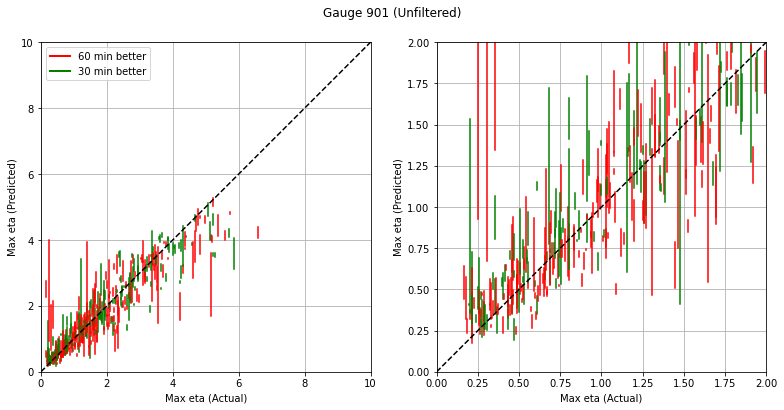

In [33]:
plot_test_all(target_901,pred_901,10,2, plotlabels)
suptitle('Gauge 901 (Unfiltered)', y = 0.9)
# plt.savefig('g901_subs.png')

Text(0.5, 0.9, 'Gauge 901 (Filtered)')

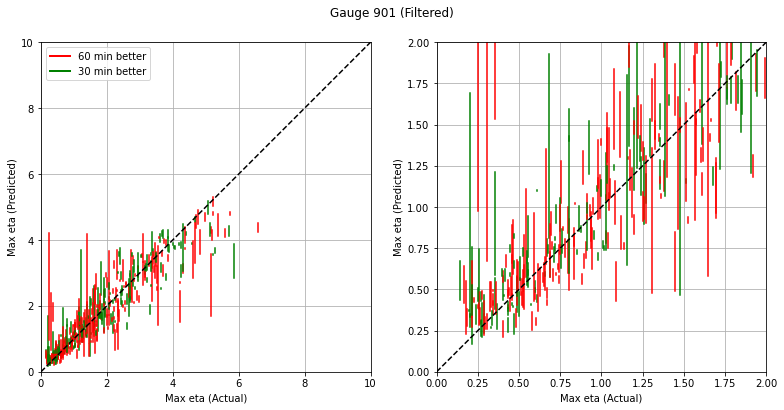

In [34]:
plot_test_all(target_901_f,pred_901_f,10,2, plotlabels)
suptitle('Gauge 901 (Filtered)',y=0.9)
# plt.savefig('g901_f_subs.png')

#### 902

Text(0.5, 0.9, 'Gauge 902 (Unfiltered)')

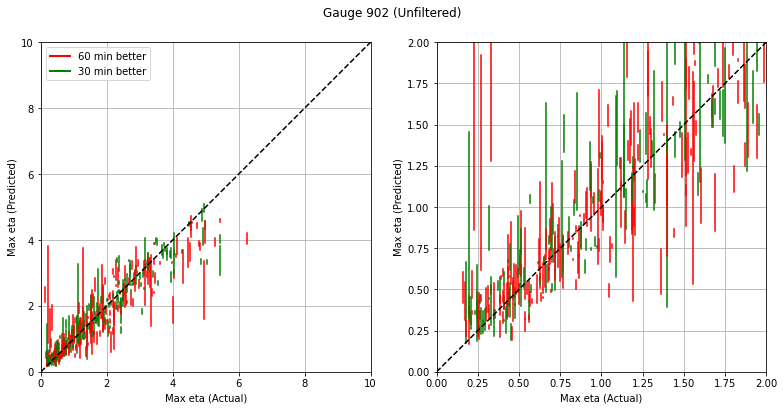

In [35]:
plot_test_all(target_902,pred_902,10,2, plotlabels)
suptitle('Gauge 902 (Unfiltered)',y=0.9)
# plt.savefig('g902_subs.png')

Text(0.5, 0.9, 'Gauge 902 (Filtered)')

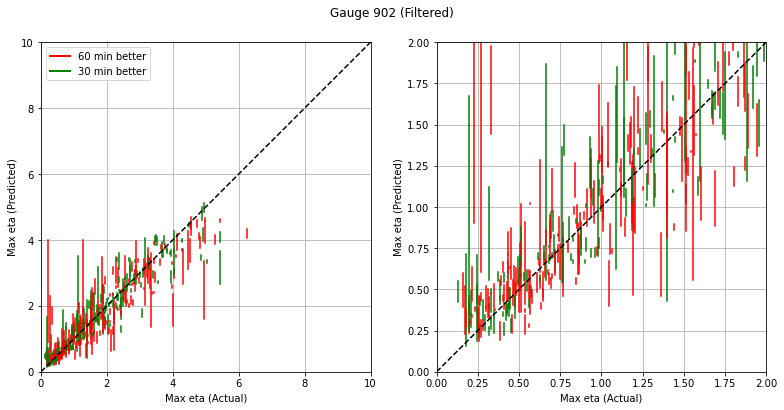

In [36]:
plot_test_all(target_902_f,pred_902_f,10,2, plotlabels)
suptitle('Gauge 902 (Filtered)',y=0.9)
# plt.savefig('g902_f_subs.png')

#### 911

Text(0.5, 0.9, 'Gauge 911 (Unfiltered)')

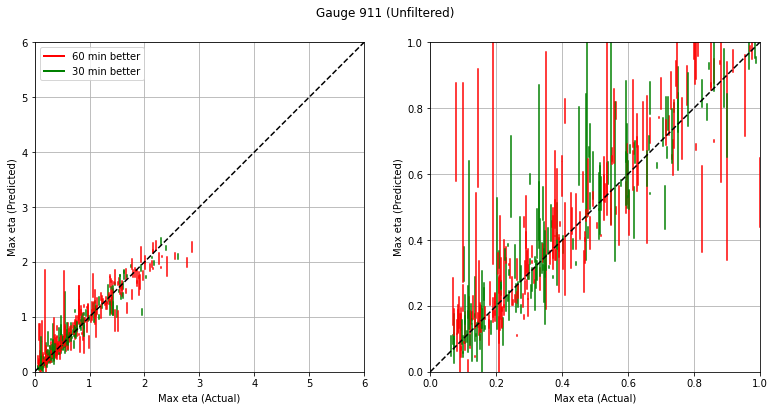

In [37]:
plot_test_all(target_911,pred_911,6,1, plotlabels)
suptitle('Gauge 911 (Unfiltered)',y=0.9)
# plt.savefig('g911_subs.png')

Text(0.5, 0.9, 'Gauge 911 (Filtered)')

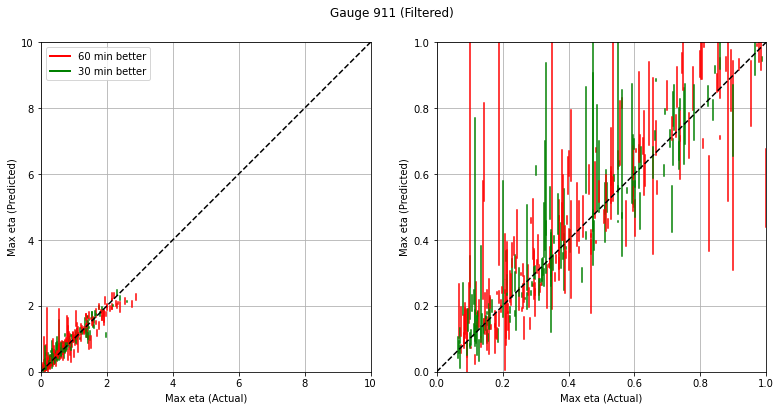

In [38]:
plot_test_all(target_911_f,pred_911_f,10,1, plotlabels)
suptitle('Gauge 911 (Filtered)', y=0.9)
# plt.savefig('g911_f_subs.png')

#### 912

Text(0.5, 0.9, 'Gauge 912 (Unfiltered)')

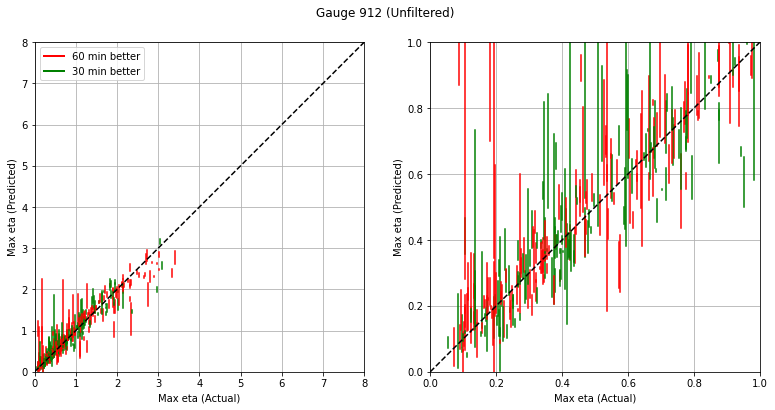

In [39]:
plot_test_all(target_912,pred_912,8,1, plotlabels)
suptitle('Gauge 912 (Unfiltered)',y=0.9)
# plt.savefig('g912_subs.png')

Text(0.5, 0.98, 'Gauge 912 (Filtered)')

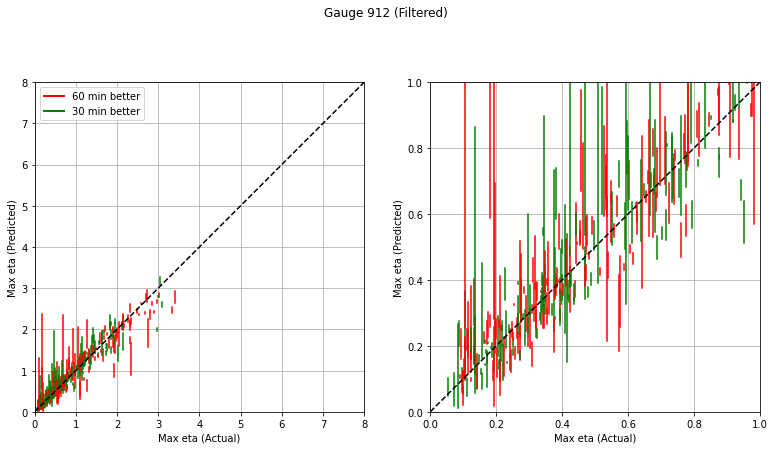

In [40]:
plot_test_all(target_912_f,pred_912_f,8,1, plotlabels)
suptitle('Gauge 912 (Filtered)')
# plt.savefig('g912_subs_f.png')

### Train Models: Classification

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
# Filter
feat702_filt901_c = filter_features(feat702, g901max_c, 'c')
feat702_filt902_c = filter_features(feat702, g902max_c, 'c')
feat702_filt911_c = filter_features(feat702, g911max_c, 'c')
feat702_filt912_c = filter_features(feat702, g912max_c, 'c')

In [43]:
rseed_rng = np.arange(5)

### Gauge 901

In [44]:
accs_901 = []
for seed in rseed_rng:
    rseed = seed
    
    # Unfiltered
    pred_901_c, target_901_c, runs_901_c, acc_901_c = train_test(feat702, g901max_c, runs_used, scale=True, c_or_r='c')

    # Filtered
    pred_901_c_f, target_901_c_f, runs_901_c_f, acc_901_c_f = train_test(feat702_filt901_c, g901max_c,
                                                                     runs_used, scale=True, c_or_r='c')
    
    accs_901.append(np.vstack((acc_901_c, acc_901_c_f)))

In [45]:
accs_901 #doesn't seem to be much variance

[array([[0.78587699, 0.83599089],
        [0.76765376, 0.80637813]]),
 array([[0.80410023, 0.79271071],
        [0.79498861, 0.76537585]]),
 array([[0.81776765, 0.80865604],
        [0.81321185, 0.81321185]]),
 array([[0.76993166, 0.80410023],
        [0.78587699, 0.79726651]]),
 array([[0.7881549 , 0.78587699],
        [0.82460137, 0.80637813]])]

### Gauge 902

In [46]:
#lets play around with lasso

# clfl = Lasso(alpha=5)
# clfl.fit(A_tr, B_tr)

# x5_lso = clfl.coef_
# x5_lso = x5_lso.transpose()

In [47]:
# Unfiltered
pred_902_c, target_902_c, runs_902_c, acc_902_c = train_test(feat702, g902max_c, runs_used, scale=True, c_or_r='c')

# Filtered
pred_902_c_f, target_902_c_f, runs_902_c_f, acc_902_c_f = train_test(feat702_filt902_c, g902max_c, 
                                                                     runs_used, scale=True, c_or_r='c')

In [48]:
np.vstack((acc_902_c, acc_902_c_f))

array([[0.7904328 , 0.83371298],
       [0.79498861, 0.81321185]])

### Gauge 911

In [49]:
# Unfiltered
pred_911_c, target_911_c, runs_911_c, acc_911_c = train_test(feat702, g911max_c, runs_used, scale=True, c_or_r='c')

# Filtered
pred_911_c_f, target_911_c_f, runs_911_c_f, acc_911_c_f = train_test(feat702_filt911_c, g911max_c, 
                                                                     runs_used, scale=True, c_or_r='c')

In [50]:
np.vstack((acc_911_c, acc_911_c_f))

array([[0.97266515, 0.97494305],
       [0.97722096, 0.98405467]])

### Gauge 912

In [51]:
# Unfiltered
pred_912_c, target_912_c, runs_912_c, acc_912_c = train_test(feat702, g912max_c, runs_used, scale=True, c_or_r='c')

# Filtered
pred_912_c_f, target_912_c_f, runs_912_c_f, acc_912_c_f = train_test(feat702_filt912_c, g912max_c, runs_used, scale=True, c_or_r='c')

In [52]:
np.vstack((acc_912_c, acc_912_c_f))

array([[0.95216401, 0.92938497],
       [0.93621868, 0.9453303 ]])

## Plotting Specific Runs

Code used for finding the run numbers of the most inaccurate predictions and plotting them. This section requires the interpolated data to be loaded.

In [53]:
def find_inacc_runs(pred, target, runs, n):
    
    """
        Finds runs of the n largest absolute difference between predicted and actual and outputs a pandas dataframe. 

        Input:
               pred - Prediction from regression model
               target - Actual max eta value
               runs - run numbers used for the testing set
               n - number of largest absolute differences returned
               
        Output:
            pd.Dataframe - pandas datafram containing the run numbers, predicted and actual eta, and absolute difference
                           of predicted and actual.
    """
    
    difference = np.abs(pred-target)
    ind = difference.argsort()[-n:][::-1]
    
    run_dict = {'Run Number' : np.array(runs)[ind], 'Predicted' : pred[ind], 'Actual' : target[ind], 
                    'Abs Diff': difference[ind]}
    
    return pd.DataFrame(data = run_dict)
    

In [54]:
def find_run(pred, target, runs, run_num):
    """
    Prints predicted and actual max eta for a specified run. 

    Input:
           pred - Prediction from regression model
           target - Actual max eta value
           runs - run numbers used for the testing set
           run_num - specified run number

    """

    ind = np.where(runs == run_num)
    
    if len(ind[0]) == 1:
        print("Run Number:" + str(run_num) + ", Predicted:" + str(pred[ind]) + ", Actual:" + str(target[ind]))
    else:
        print("Run not found.")

In [55]:
def plot_run(rnum, gaugeno, winnum, *pred):
    
    """
       Plots gauge 702 and a specified 9XX gauge for a specified run number
       
       Input:
           rnum - Run number of interest
           gaugeno - Gauge number of interest
           *pred - optional argument for printing predicted value on title of plot
    """
    
    fig, (ax1, ax2) = plt.subplots(2,sharex=True, sharey=True,figsize=(12,10))
    
    title = 'Run # %s' % rnum
    
    if pred:
        title =title + ', Predicted: %sm' % np.around(pred[0],2)
    
    ax1.set_title(title, fontsize=20,)
    
    fig.add_subplot(111, frameon=False) # used for centering the y-axis label
    
    ax1.plot(t[(rnum,702)]/60, eta[(rnum,702)], label="Gauge # 702", color='blue')
    ax1.grid(True)
    ax1.legend(loc='upper left')
    
    
    #Plot window of data used and reference line for threshold. 
    start = tstart[winnum][runs_used[winnum].index(rnum)]*10
    end = (start + (tsteps[winnum]-1)*10)
    ax1.axvline(start/60, color ='red', ls='--', lw=1, alpha = 0.8)
    ax1.axvline(end/60, color ='red', ls='--', lw=1, alpha = 0.8)
    ax1.axhline(threshold,color='red',alpha = 0.2)
    ax1.axhline(-threshold,color='red',alpha = 0.2)

    ax2.plot(t[(rnum,gaugeno)]/60, eta[(rnum,gaugeno)], label='Gauge # %s' % gaugeno, color='blue')
    ax2.grid(True)
    ax2.legend(loc='upper left')
    
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False) # used for centering the y-axis label
    plt.xlabel('Minutes after quake', fontsize=16)
    plt.ylabel('Surface elevation (meters)', fontsize=16)

In [56]:
def save_run_plots(rnums, pred, gaugeno):
    """
        Saves plots of eta for specified runs of gauge 702 and a specified gauge 9XX as a png.
        
        Input:
           rnums - Run numbers of interest
           pred - Predicted values for runs of interest
           gaugeno - Gauge number of interest
    """
    for i in range(len(rnums)):
        # suppress inline output
        %matplotlib agg 
        
        plot_run(rnums[i], gaugeno, pred[i])
        plt.savefig("r%s_g%s.png" % (rnums[i],gaugeno))
        
        # suppress inline output
        %matplotlib agg 

In [57]:
# Naming Scheme for predictions, test targets and runs used for testing AND for filtered and unfiltered
# pred_9XX or pred_9XX_f
# target_9XX or target_9XX_f
# runs_9XX or runs_9XX_f

badruns = find_inacc_runs(pred_901[0], target_901[0], runs_901[0], 15)

In [58]:
badruns

,Run Number,Predicted,Actual,Abs Diff
0,360,3.983222,0.253884,3.729338
1,823,1.700293,5.171570,3.471277
2,1048,1.557747,4.226765,2.669018
3,196,2.744057,0.141742,2.602315
4,645,3.934168,1.396765,2.537402
5,1249,4.050257,6.584961,2.534704
6,593,1.468571,3.554403,2.085831
7,1052,4.056535,5.840230,1.783695
8,766,2.134587,0.353152,1.781435
9,1295,2.830053,4.610783,1.780729


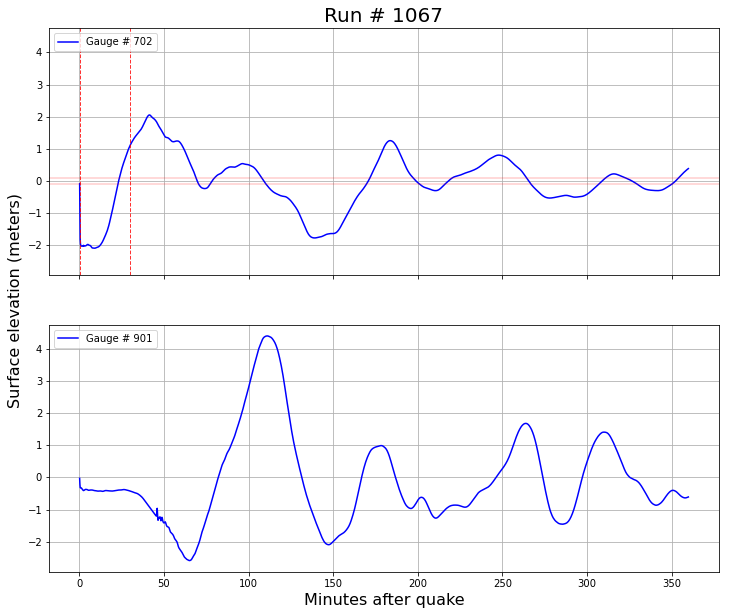

In [59]:
%matplotlib inline

plot_run(1067,901,0)

In [60]:
find_run(pred_911, target_911, runs_911, 943)

Run not found.


In [61]:
# save_run_plots(badruns['Run Number'].tolist(), badruns['Predicted'].tolist(),901)

## Comparing results when magnitude and latitude of centroid of slip are added

Calculating the magnitude of the earthquake and latitude of the centroid of the slip could be possible in the case of real-time forecasting.

In [119]:
rseed = 1 

### Add features to the training data

In [120]:
maglat = np.genfromtxt('C:/Users/Chris/Desktop/fakequake_info.txt', delimiter=',')
maglat_df = pd.DataFrame(data=maglat[runs_used[0],1:], index=maglat[runs_used[0],0], columns = ['Magnitude','Lat'])
feat702_maglat = [pd.concat([maglat_df, feat702[0]], axis=1), pd.concat([maglat_df, feat702[1]], axis=1)]

In [121]:
feat702_maglat[1]

,Magnitude,Lat,eta__abs_energy,eta__absolute_sum_of_changes,"eta__agg_autocorrelation__f_agg_""mean""__maxlag_40","eta__agg_autocorrelation__f_agg_""median""__maxlag_40","eta__agg_autocorrelation__f_agg_""var""__maxlag_40","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""",...,eta__symmetry_looking__r_0.1,eta__symmetry_looking__r_0.15000000000000002,eta__symmetry_looking__r_0.2,eta__symmetry_looking__r_0.25,eta__time_reversal_asymmetry_statistic__lag_1,eta__time_reversal_asymmetry_statistic__lag_2,eta__time_reversal_asymmetry_statistic__lag_3,eta__variance,eta__variance_larger_than_standard_deviation,eta__variation_coefficient
1.0,8.02,47.17,4.191336,0.829330,0.767737,0.796574,0.030001,0.061233,0.055560,0.049676,...,1.0,1.0,1.0,1.0,0.000020,0.000038,0.000054,0.011515,0.0,-10.968321
5.0,7.92,48.64,2.366194,0.953658,0.758782,0.730863,0.019291,-0.049937,-0.058534,-0.067071,...,0.0,1.0,1.0,1.0,0.000002,0.000004,0.000006,0.006438,0.0,7.416966
10.0,7.68,49.06,2.533864,0.345826,0.949382,0.962649,0.002157,-0.099307,-0.103781,-0.108040,...,0.0,1.0,1.0,1.0,0.000004,0.000008,0.000012,0.006928,0.0,8.735462
11.0,7.80,47.77,4.022819,1.208667,0.679627,0.737073,0.068412,-0.012371,-0.028452,-0.044248,...,1.0,1.0,1.0,1.0,0.000004,0.000008,0.000012,0.010847,0.0,6.047468
13.0,7.87,47.49,1.253431,0.375565,0.883358,0.892092,0.007027,0.080778,0.076344,0.071751,...,1.0,1.0,1.0,1.0,-0.000004,-0.000008,-0.000012,0.003457,0.0,15.306536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294.0,8.97,42.93,26.100175,1.664593,0.842221,0.865955,0.017016,0.416058,0.392548,0.368657,...,1.0,1.0,1.0,1.0,0.000031,0.000058,0.000081,0.026853,0.0,0.768675
1295.0,9.25,44.20,137.757617,1.905916,0.840034,0.853246,0.011562,-0.696677,-0.694021,-0.686429,...,0.0,0.0,0.0,1.0,0.012919,0.025976,0.039133,0.361448,0.0,4.235051
1296.0,8.95,46.16,150.227005,4.016679,0.871932,0.881236,0.007823,-0.504901,-0.613856,-0.669099,...,1.0,1.0,1.0,1.0,0.001474,0.005817,0.011103,0.377390,0.0,3.120683
1297.0,9.05,46.10,206.874845,5.104523,0.888615,0.898478,0.006284,-0.976796,-1.055160,-1.097424,...,1.0,1.0,1.0,1.0,0.004851,0.009579,0.014855,0.568321,0.0,10.950520


### Testing and Training

#### 901

In [122]:
# Unfiltered
pred_901_ml, target_901_ml, runs_901_ml, evs_901_ml = train_test(feat702_maglat, g901max, runs_used, scale=True, c_or_r='r')

In [123]:
evs_901_ml

[0.8029609738161775, 0.8641658141929501]

In [124]:
evs_901

[0.7983018900707595, 0.8635788379876024]

Text(0.5, 0.9, 'Gauge 901 (Unfiltered, with mag and lat)')

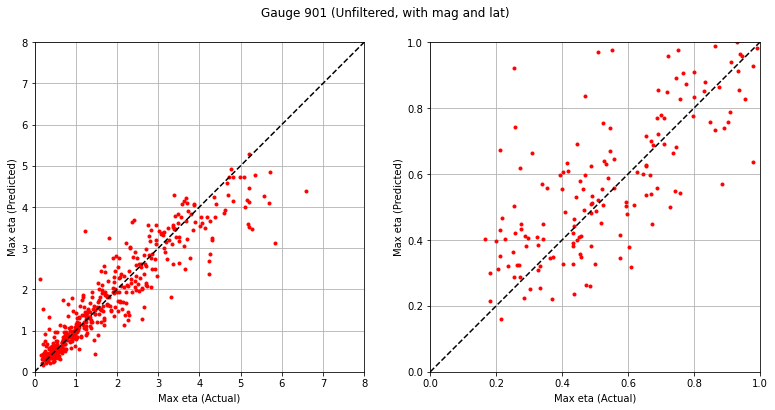

In [125]:
plot_test(target_901_ml,pred_901_ml,8,1,1)
suptitle('Gauge 901 (Unfiltered, with mag and lat)',y=0.9)

Text(0.5, 0.9, 'Gauge 901 (Unfiltered, with mag and lat)')

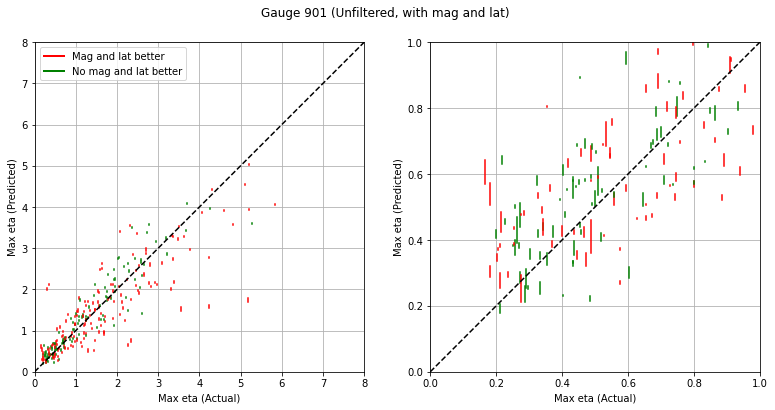

In [126]:
plotlabels = ['Mag and lat better', 'No mag and lat better']
plot_test_all([target_901[0],target_901_ml[0]],[pred_901[0],pred_901_ml[0]],8,1, plotlabels)
suptitle('Gauge 901 (Unfiltered, with mag and lat)',y=0.9)
# plt.savefig('g901_ml_subs.png')

#### 911

In [127]:
# Unfiltered
pred_911_ml, target_911_ml, runs_911_ml, evs_911_ml = train_test(feat702_maglat, g911max, runs_used, scale=True, c_or_r='r')

In [128]:
evs_911_ml

[0.8647759555819997, 0.9285473728686917]

In [129]:
evs_911

[0.8621314884421766, 0.9284945455192303]

Text(0.5, 0.9, 'Gauge 911 (Unfiltered, with mag and lat)')

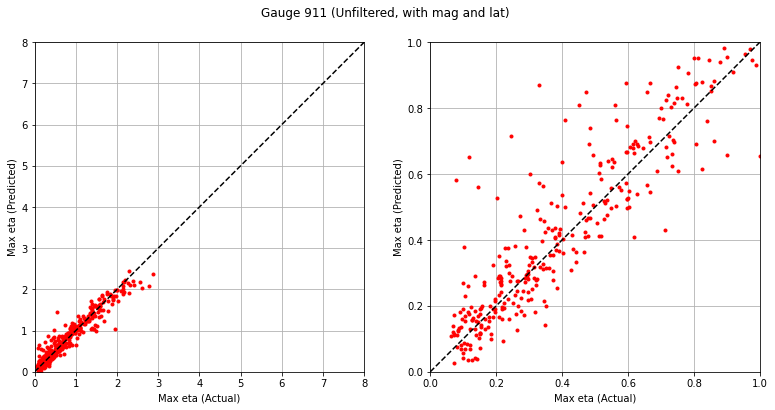

In [130]:
plot_test(target_911_ml,pred_911_ml,8,1,1)
suptitle('Gauge 911 (Unfiltered, with mag and lat)',y=0.9)

Text(0.5, 0.9, 'Gauge 911 (Unfiltered, with mag and lat)')

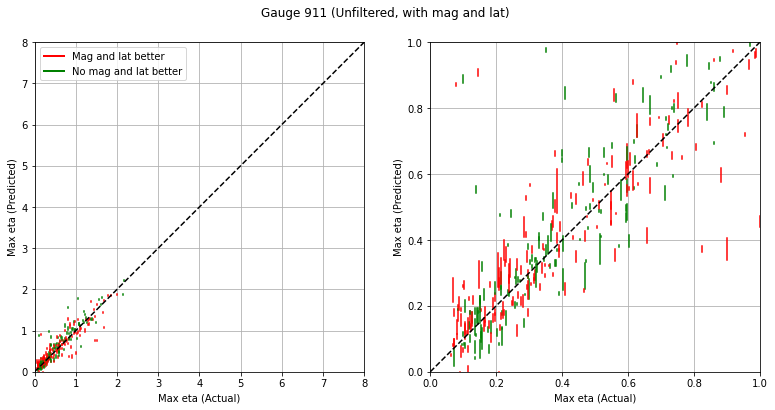

In [131]:
plot_test_all([target_911[0],target_911_ml[0]],[pred_911[0],pred_911_ml[0]],8,1, plotlabels)
suptitle('Gauge 911 (Unfiltered, with mag and lat)',y=0.9)
# plt.savefig('g911_ml_subs.png')

## Compare Scaling/Normalization

In [132]:
pred_901_ns, target_901_ns, runs_901_ns, evs_901_ns = train_test(feat702, g901max, runs_used, scale=False, c_or_r='r')

Text(0.5, 0.9, 'Gauge 901 (Unfiltered, with and without scaling)')

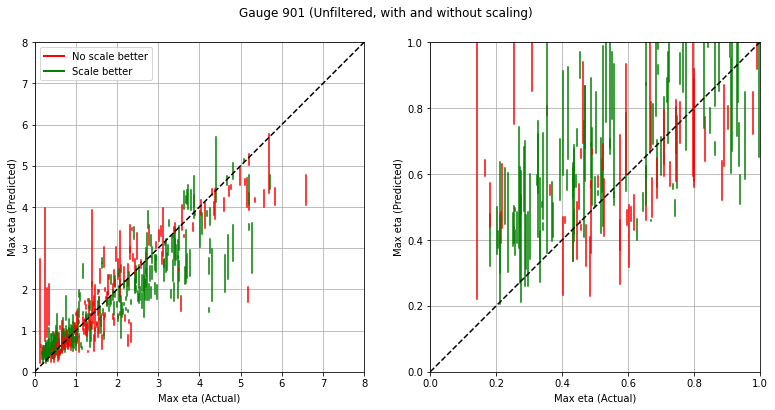

In [133]:
plotlabels = ['No scale better', 'Scale better']
plot_test_all([target_901[0],target_901_ns[0]],[pred_901[0],pred_901_ns[0]],8,1, plotlabels)
suptitle('Gauge 901 (Unfiltered, with and without scaling)',y=0.9)
# plt.savefig('g901_scale_subs.png')

In [134]:
find_inacc_runs(pred_901[0], pred_901_ns[0], runs_901[0], 15)

,Run Number,Predicted,Actual,Abs Diff
0,360,3.983222,0.752224,3.230998
1,645,3.934168,1.370876,2.563292
2,196,2.744057,0.220042,2.524015
3,725,3.405449,1.701709,1.703740
4,974,3.364879,1.731014,1.633865
5,1067,4.113608,5.684864,1.571255
6,993,4.337822,5.763720,1.425898
7,1254,3.428427,2.153213,1.275213
8,1251,2.984536,1.729164,1.255372
9,1135,3.598255,2.401006,1.197249


## Visualizing Significance

In [135]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh import defaults, extract_features

In [136]:
FDR_LEVEL = defaults.FDR_LEVEL
HYPOTHESES_INDEPENDENT = defaults.HYPOTHESES_INDEPENDENT

In [137]:
index = pd.Series(range(1300))
feat702_relevance = pd.read_csv (r'feat702_all_910.csv')

In [138]:
df_pvalues_mann = calculate_relevance_table(feat702_relevance.set_index(index), pd.Series(max_eta_all(eta,901,1300)), 
                                            fdr_level=FDR_LEVEL, test_for_real_target_real_feature='mann')

In [139]:
feat702_relevance

,eta__abs_energy,eta__absolute_sum_of_changes,"eta__agg_autocorrelation__f_agg_""mean""__maxlag_40","eta__agg_autocorrelation__f_agg_""median""__maxlag_40","eta__agg_autocorrelation__f_agg_""var""__maxlag_40","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","eta__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""",...,eta__spkt_welch_density__coeff_8,eta__standard_deviation,eta__sum_values,eta__symmetry_looking__r_0.05,eta__time_reversal_asymmetry_statistic__lag_1,eta__time_reversal_asymmetry_statistic__lag_2,eta__time_reversal_asymmetry_statistic__lag_3,eta__variance,eta__variance_larger_than_standard_deviation,eta__variation_coefficient
0,2.412246,0.679106,0.964136,0.973248,0.001101,0.000935,-0.000914,-0.002687,3.029241e-06,0.009132,...,3.841084e-06,0.033421,1.219225,1.0,1.017066e-11,3.619885e-11,4.578725e-11,0.001117,0.0,59.182217
1,13.370748,3.054860,0.868627,0.897225,0.013059,0.008716,0.002389,-0.003847,3.562167e-05,0.037286,...,3.728982e-05,0.078685,-2.847386,1.0,2.576779e-08,4.257236e-08,4.499135e-08,0.006191,0.0,-59.661858
2,0.331196,0.259946,0.965037,0.975029,0.001104,0.001598,0.001498,0.001406,3.566421e-08,0.002319,...,1.001003e-06,0.012382,-0.644902,1.0,-1.054159e-11,-2.748929e-11,-5.314523e-11,0.000153,0.0,-41.452304
3,0.640058,0.379195,0.943330,0.955231,0.002297,0.000310,0.000077,-0.000150,6.691218e-08,0.000783,...,9.502599e-07,0.017218,-0.213626,1.0,1.440807e-08,2.983190e-08,4.622280e-08,0.000296,0.0,-174.010635
4,0.025222,0.067010,0.968109,0.977516,0.000943,0.000441,0.000432,0.000424,6.418344e-10,0.000457,...,9.803306e-10,0.003413,-0.388539,1.0,1.981991e-12,3.836705e-12,5.530982e-12,0.000012,0.0,-18.966184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,1948.151775,18.598585,0.970711,0.978939,0.000774,0.149417,0.106535,0.064645,1.476783e-03,0.311533,...,1.236182e-03,0.948689,-104.193884,1.0,7.778036e-05,1.467181e-04,2.087964e-04,0.900011,0.0,-19.657771
1296,397.333034,11.667083,0.931686,0.940737,0.002730,0.031642,-0.017963,-0.063791,4.694734e-03,0.231862,...,1.958362e-03,0.428742,-31.726885,1.0,2.054656e-05,1.192284e-04,3.195020e-04,0.183820,0.0,-29.175700
1297,679.818634,14.975432,0.936493,0.946596,0.002644,0.047269,-0.016829,-0.072190,3.388180e-03,0.298513,...,3.767531e-03,0.561031,-23.749379,1.0,1.672917e-05,8.490341e-05,1.863580e-04,0.314756,0.0,-51.001990
1298,1009.078932,13.551831,0.967809,0.976695,0.000931,0.054127,0.019049,-0.015702,1.083996e-03,0.194561,...,5.505635e-04,0.683643,-8.430481,1.0,4.810649e-07,1.272088e-06,2.692250e-06,0.467367,0.0,-175.077140


In [140]:
# df_pvalues_mann.head(10)

[]

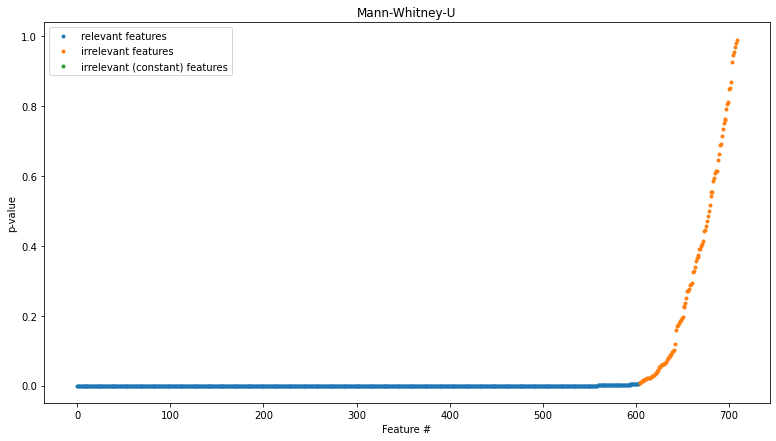

In [141]:
figure(figsize=(13,7))
df_pvalues_mann.index = pd.Series(range(0, len(df_pvalues_mann.index)))

df_pvalues_mann.p_value.where(df_pvalues_mann.relevant)\
    .plot(style=".", label="relevant features")

df_pvalues_mann.p_value.where(~df_pvalues_mann.relevant & (df_pvalues_mann.type != "const"))\
    .plot(style=".", label="irrelevant features")

df_pvalues_mann.p_value.fillna(1).where(df_pvalues_mann.type == "const")\
    .plot(style=".", label="irrelevant (constant) features")

plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Mann-Whitney-U")
plt.legend()
plt.plot()


# Forecast on Real data

Data not generated with the K-L expansion idea and is supposed to be a model for the event of January 26, 1700

## Load and Interp Data

In [142]:
gdata = np.loadtxt(r'C:\Users\Chris\Dropbox\Tsunami Research\Forecast 1700 Event\gauge00702.txt')


t702_f     = gdata[:,1]  # seconds
eta702_f   = gdata[:,5]  # surface elevation in meters

tt = np.arange(0., t702_f[-1], 10)

gaugefcn = interp1d(t702_f , eta702_f, kind='linear', bounds_error=False)
eta_unif_702 = gaugefcn(tt)
tt702_f = tt
   
# set a value of 0 to the first data point since it is NaN due to interp. This fails when I don't capture that initial drop
eta_unif_702[0]=0 

#### Plot gauge

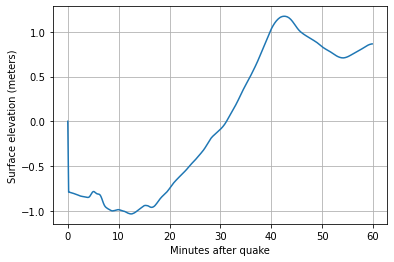

In [143]:
plot(tt702_f/60, eta_unif_702)

xlabel('Minutes after quake')
ylabel('Surface elevation (meters)')
grid(True)

## Featurize

In [144]:
feat_702_f = []

dict = {'id':np.ones(len(eta_unif_702[0:180])), 'time':tt702_f[0:180], 'eta': eta_unif_702[0:180]}
feat_702_f.append(extract_features(pd.DataFrame(dict), column_id='id', column_sort='time', kind_to_fc_parameters=params_30min))  

dict = {'id':np.ones(len(eta_unif_702)), 'time':tt702_f, 'eta': eta_unif_702}
feat_702_f.append(extract_features(pd.DataFrame(dict), column_id='id', column_sort='time', kind_to_fc_parameters=params_60min))

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


## Predict

In [145]:
def predict(scalers,models,feats):
    scalers_f = scalers
    models_f = models
    
    pred = []

    for i in range(len(feats)):
        scale_temp = scalers_f[i]
        model_temp = models_f[i]
        ft_temp = feats[i]

        pred.append(model_temp.predict(scale_temp.transform(ft_temp[ft_temp.columns]))[0])
    
    return pred

In [146]:
predf_901 = predict(scalers_901,models_901,feat_702_f)
predf_902 = predict(scalers_902,models_902,feat_702_f)
predf_911 = predict(scalers_911,models_911,feat_702_f)
predf_912 = predict(scalers_912,models_912,feat_702_f)

In [147]:
np.vstack((predf_901,predf_902,predf_911,predf_912))

array([[3.54817464, 3.07783148],
       [3.32065649, 2.88880451],
       [1.85266279, 1.35815883],
       [1.92742808, 1.50860589]])